#Install Libraries

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import utility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import data import libraries
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import pandas_ta as pta

#Import data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Import DL libraries
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, Dropout,Bidirectional, Input, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Import Data

In [ ]:
base_stock = "HDFCBANK.NS"
test_stock = "ICICIBANK.NS"

In [ ]:
df = pdr.get_data_yahoo(base_stock , start="1980-02-01", end="2022-07-13")

[*********************100%***********************]  1 of 1 completed


In [ ]:
del_arr = []
for i in range(0, df.shape[0]):
  if df.iloc[i][0] ==  df.iloc[i][1] == df.iloc[i][2] ==  df.iloc[i][3]:
    del_arr.append(i)


In [ ]:
# df = df.iloc[::-1]
# print(df)

#Feature Selection

##What aer the different features we can use, keep in mind we want to solve the problem of scaling and predict tomorrow's price

**So what is the problem with scaling using minmaxscaler or standard scaler on general problems? **

-> If we fit the scaler on Nifty data which ranges from (4000 to 11000), the newer stock values when transformed will have very low values (less pattern similarity corresponding to only 20% of initial training dataset).


**What if we use different scalers?**

-> Even if we use different scalers,

  -> There is a problem of data not being normalized. The patterns in the chart will range from 0-0.3 (for first 20% data) and so on, be divided into brackets.

**So we conclude we need to normalize the data. As we are only using univariate feature, what do you propose? **

-> I propose 2 solutions,
  
  -> Create batches using unscaled data. Then scale the data on the individual batches. Handling only a single feature makes this task simpler as we can create batches with the targets, scale them, and then seperate them. We have 2 options for scaling, 1 would be use a standard scaler but in that case, we would have to store all the scalers (equal to the number of batches). What we can do instead is scale it ourselves using mean and std dv and store these values in a dictionary against batch number so original value can be retrieved after transformation. I will try the standardscaling function to check the mse, in my opinion it should perform better and give a lower mse value.

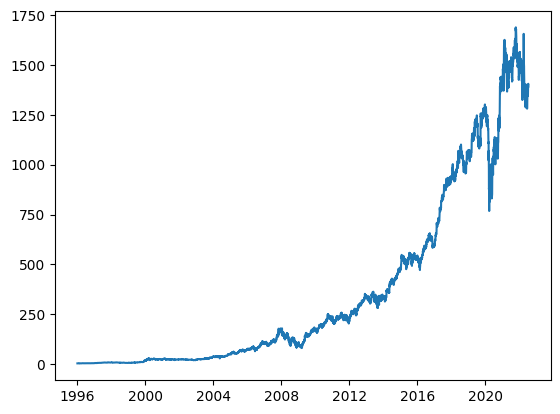

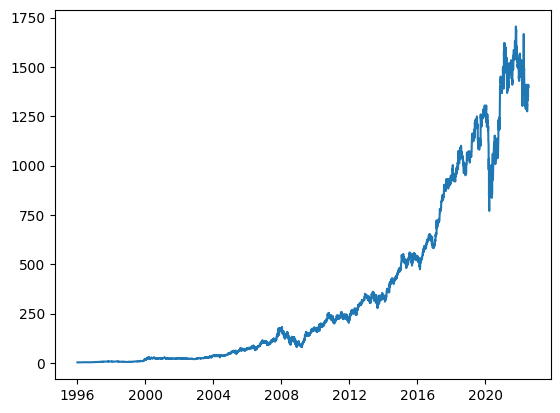

In [ ]:
plt.plot(df['Close'])
plt.show()
plt.plot(df['Open'])
plt.show()

#Unconventional method of scaling using Open and Close


##Create Targets and scale the data

The target is going to be next day's closing price. The batches will be create accordingly.

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,3.030,3.030000,2.925000,2.980000,2.389958,350000
1996-01-02,2.980,3.025000,2.950000,2.975000,2.385947,412000
1996-01-03,2.975,2.995000,2.950000,2.985000,2.393967,284000
1996-01-04,2.985,2.980000,2.940000,2.965000,2.377927,282000
1996-01-05,2.965,2.980000,2.950000,2.960000,2.373918,189000
...,...,...,...,...,...,...
2022-07-06,1348.000,1373.400024,1347.099976,1371.250000,1371.250000,7524539
2022-07-07,1380.000,1398.000000,1374.449951,1395.800049,1395.800049,8871571
2022-07-08,1410.000,1410.000000,1394.750000,1397.099976,1397.099976,6237015


In [ ]:
feature = np.array(df[['Open', 'Close']])

print(feature.shape)

import math

training_data_len = math.ceil(feature.shape[0] *0.8)
print(training_data_len)
training_data = feature[:training_data_len]
testing_data = feature[training_data_len:]
print(training_data.shape, testing_data.shape)

(6676, 2)
5341
(5341, 2) (1335, 2)


In [ ]:
batches_training = []
targets_training = []

for i in range(30,len(training_data)):
    buffer_array = list(training_data[i-30:i])
    targets_training.append(training_data[i][0])
    batches_training.append(buffer_array)

print(np.array(batches_training).shape, np.array(targets_training).shape)

(5311, 30, 2) (5311,)


In [ ]:
#Define batch scaling function
scaled_training_data = []
scaled_training_targets = []

def scale(x, buffer_target):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  new_seq = []
  for j in seq_x:
    buffer_seq = []
    for k in j:
      new_k = (k-min_x)/(max_x-min_x)
      buffer_seq.append(new_k)
    new_seq.append(buffer_seq)
  scaled_target = (buffer_target-min_x)/(max_x-min_x)
  return new_seq, scaled_target

for i in range(0, len(batches_training)):
  seq = batches_training[i]
  buffer_target = targets_training[i]
  new_seq, scaled_target = scale(seq, buffer_target)
  scaled_training_data.append(new_seq)
  scaled_training_targets.append(scaled_target)

x_train = np.array(scaled_training_data)
y_train = np.array(scaled_training_targets)

print(np.array(scaled_training_data).shape, np.array(scaled_training_targets).shape)

(5311, 30, 2) (5311,)


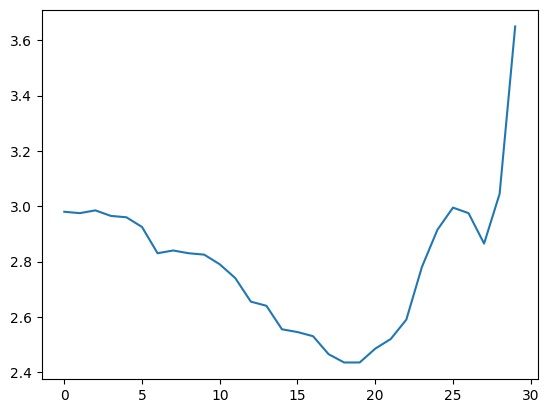

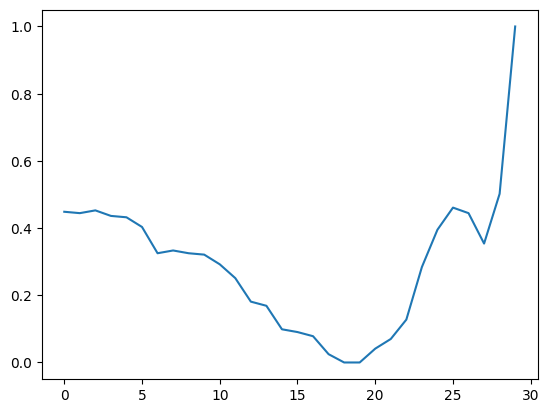

In [ ]:
plt.plot(pd.DataFrame(batches_training[0])[1])
plt.show()
plt.plot(pd.DataFrame(scaled_training_data[0])[1])
plt.show()

In [ ]:
# np.array(scaled_data).shape

# x_train = []
# y_train = []
# for i in range(0, len(scaled_data)):
#     seq = scaled_data[i]
#     x_train.append(seq[0:-1])
#     y_train.append(seq[-1])

# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# print(x_train.shape, y_train.shape)

##Model Architecture

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
## epochs = 9
history = model.fit(x_train, y_train, batch_size=256, epochs=40, validation_split=0.2)

Epoch 1/40
17/17 [==============================] - 13s 348ms/step - loss: 0.1320 - val_loss: 0.0849
Epoch 2/40
17/17 [==============================] - 5s 314ms/step - loss: 0.0671 - val_loss: 0.0536
Epoch 3/40
17/17 [==============================] - 4s 258ms/step - loss: 0.0526 - val_loss: 0.0415
Epoch 4/40
17/17 [==============================] - 4s 265ms/step - loss: 0.0441 - val_loss: 0.0344
Epoch 5/40
17/17 [==============================] - 6s 364ms/step - loss: 0.0392 - val_loss: 0.0312
Epoch 6/40
17/17 [==============================] - 4s 243ms/step - loss: 0.0358 - val_loss: 0.0281
Epoch 7/40
17/17 [==============================] - 2s 137ms/step - loss: 0.0323 - val_loss: 0.0246
Epoch 8/40
17/17 [==============================] - 2s 123ms/step - loss: 0.0290 - val_loss: 0.0213
Epoch 9/40
17/17 [==============================] - 5s 295ms/step - loss: 0.0254 - val_loss: 0.0193
Epoch 10/40
17/17 [==============================] - 4s 239ms/step - loss: 0.0225 - val_loss: 0.015

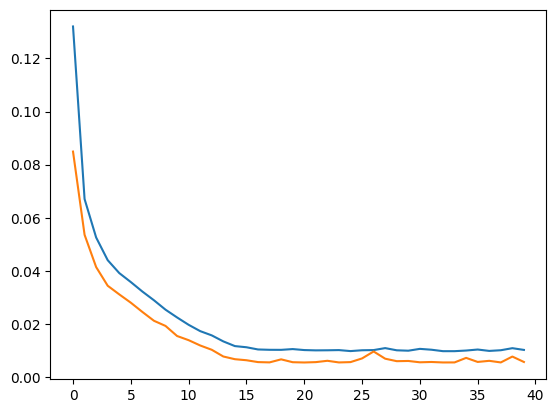

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

##Creating testing batches

In [ ]:
batches_testing = []
targets_testing = []

for i in range(30,len(testing_data)):
    buffer_array = list(testing_data[i-30:i])
    targets_testing.append(testing_data[i][0])
    batches_testing.append(buffer_array)

print(np.array(batches_testing).shape, np.array(targets_testing).shape)

(1305, 30, 2) (1305,)


In [ ]:
#Define batch scaling function
scaled_testing_data = []
scaled_testing_targets = []

scaling_dict = {}
def inverse_scale_data(x, min_x, max_x):
  orig_seq = []
  for j in x:
    buffer_array = []
    for k in j:
      orig_k = k*(max_x-min_x) + min_x
      buffer_array.append(orig_k)
    orig_seq.append(buffer_array)
  return orig_seq

def inverse_scale_target(x, min_x, max_x):
  orig_x = x*(max_x-min_x) + min_x
  return orig_x


def scale(x, buffer_target,i):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  scaling_dict[i] = (min_x, max_x)
  new_seq = []
  for j in seq_x:
    buffer_seq = []
    for k in j:
      new_k = (k-min_x)/(max_x-min_x)
      buffer_seq.append(new_k)
    new_seq.append(buffer_seq)
  scaled_target = (buffer_target-min_x)/(max_x-min_x)
  return new_seq, scaled_target


for i in range(0, len(batches_testing)):
  seq = batches_testing[i]
  buffer_target = targets_testing[i]
  new_seq, scaled_target = scale(seq, buffer_target, i)
  scaled_testing_data.append(new_seq)
  scaled_testing_targets.append(scaled_target)

print(np.array(scaled_testing_data).shape, np.array(scaled_testing_targets).shape)

(1305, 30, 2) (1305,)


In [ ]:
len(scaling_dict.keys())

1305

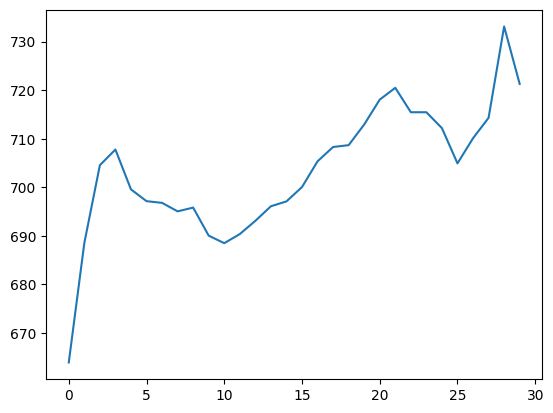

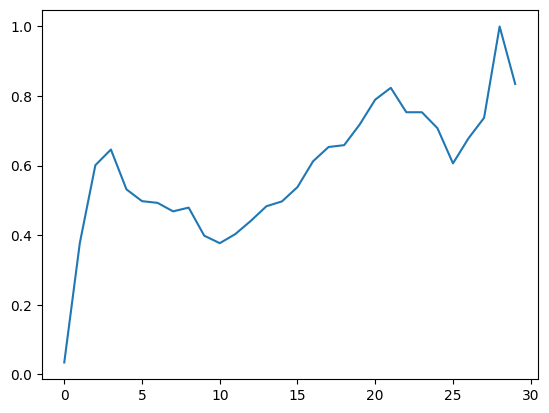

In [ ]:
plt.plot(pd.DataFrame(batches_testing[0])[1])
plt.show()
plt.plot(pd.DataFrame(scaled_testing_data[0])[1])
plt.show()

(30, 2)


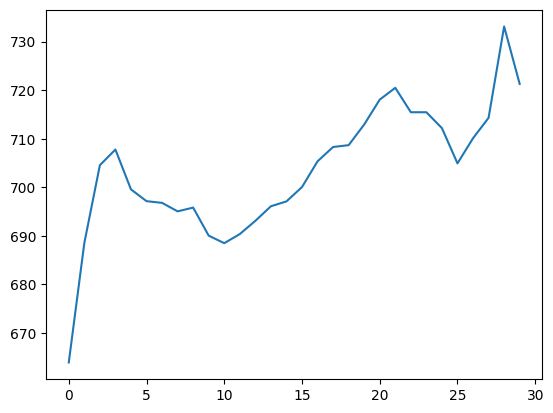

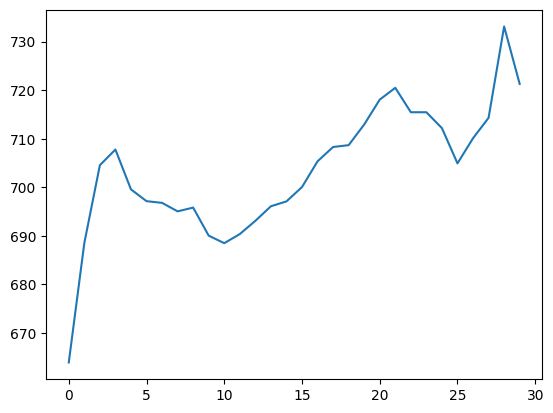

In [ ]:
dict_values = list(scaling_dict[0])

or_seq = inverse_scale_data(scaled_testing_data[0], dict_values[0], dict_values[1])
print(np.array(or_seq).shape)
plt.plot(pd.DataFrame(batches_testing[0])[1])
plt.show()
plt.plot(pd.DataFrame(or_seq)[1])
plt.show()

In [ ]:
x_test = np.array(scaled_testing_data)
y_test = np.array(scaled_testing_targets)

print(x_test.shape, y_test.shape)

(1305, 30, 2) (1305,)


##Testing

In [ ]:
base_stock_eval = model.evaluate(x_test, y_test)

41/41 [==============================] - 1s 13ms/step - loss: 0.0069


In [ ]:
prediction_list = model.predict(x_test)


41/41 [==============================] - 1s 11ms/step


In [ ]:
transformed_prediction_list = []

for i in range(0,len(prediction_list)):
    dict_values = list(scaling_dict[i])
    or_seq = inverse_scale_target(prediction_list[i], dict_values[0], dict_values[1])
    transformed_prediction_list.append(or_seq)

1305 1305


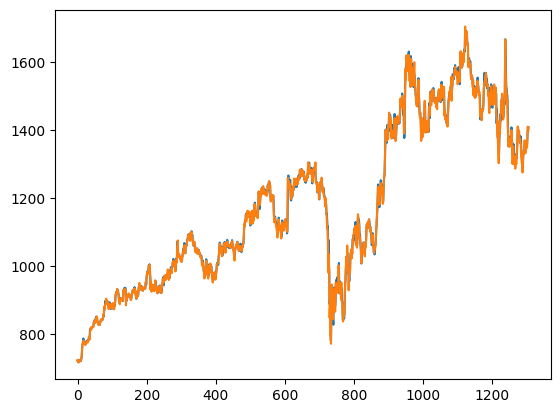

In [ ]:
print(len(transformed_prediction_list), len(testing_data[30:]))
plt.plot(transformed_prediction_list)
plt.plot(pd.DataFrame(testing_data[30:])[0])

In [ ]:
transformed_prediction_list = np.array(transformed_prediction_list)
testing_data_np = np.array(testing_data[30:][0])

print(transformed_prediction_list.shape, testing_data_np.shape)
error = 0
for i in range(0,len(testing_data_np)):
  buffer_error = math.sqrt((transformed_prediction_list[i] - testing_data_np[i])*(transformed_prediction_list[i] - testing_data_np[i]))
  error += buffer_error

base_stock_rmse = error/len(testing_data_np)
print("Final rmse: ", error/len(testing_data_np))

(1305, 1) (2,)
Final rmse:  1.6295776593932856


In [ ]:
preds, actual_close = pd.DataFrame(np.array(transformed_prediction_list)), pd.DataFrame(np.array(testing_data[30:]))

In [ ]:
dataframe = pd.concat([preds, actual_close], axis=1)

In [ ]:
dataframe.columns = ['preds', 'actual open', 'actual close']
dataframe

,preds,actual open,actual close
0,720.833191,723.000000,716.599976
1,717.692322,717.625000,716.174988
2,717.173584,715.750000,719.250000
3,720.125244,715.525024,719.424988
4,720.150452,721.500000,717.075012
...,...,...,...
1300,1355.973755,1348.000000,1371.250000
1301,1374.622925,1380.000000,1395.800049
1302,1399.395508,1410.000000,1397.099976
1303,1399.900635,1394.000000,1406.150024


In [ ]:
fp = 0
fn = 0
tn = 0
tp = 0

for i in range(0, dataframe.shape[0]-1):
    if dataframe.iloc[i+1][0] > dataframe.iloc[i][2] and dataframe.iloc[i+1][1]>dataframe.iloc[i][2]:
        tp += 1
    elif dataframe.iloc[i+1][0] > dataframe.iloc[i][2] and dataframe.iloc[i+1][1]<dataframe.iloc[i][2]:
        fp += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][2] and dataframe.iloc[i+1][1]<dataframe.iloc[i][2]:
        tn += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][2] and dataframe.iloc[i+1][1]>dataframe.iloc[i][2]:
        fn += 1

base_stock_matrix = (tp,fp,fn,tn)
base_stock_accuracy = tp/(tp+fp)

In [ ]:
print(tp,fp,fn, tn)

742 515 14 10


In [ ]:
tp /(tp +fp )

0.5902943516308672

##Testing on test_stock

In [ ]:
df_IGL = pdr.get_data_yahoo(test_stock, start="1980-02-01", end="2022-07-13")

[*********************100%***********************]  1 of 1 completed


In [ ]:
testing_data = np.array(df_IGL[['Open', 'Close']])

import math

print(testing_data.shape)

(4978, 2)


In [ ]:
batches_testing = []
targets_testing = []

for i in range(30,len(testing_data)):
    buffer_array = list(testing_data[i-30:i])
    targets_testing.append(testing_data[i][0])
    batches_testing.append(buffer_array)

print(np.array(batches_testing).shape, np.array(targets_testing).shape)

(4948, 30, 2) (4948,)


In [ ]:
#Define batch scaling function
scaled_testing_data = []
scaled_testing_targets = []

scaling_dict = {}
def inverse_scale_data(x, min_x, max_x):
  orig_seq = []
  for j in x:
    buffer_array = []
    for k in j:
      orig_k = k*(max_x-min_x) + min_x
      buffer_array.append(orig_k)
    orig_seq.append(buffer_array)
  return orig_seq

def inverse_scale_target(x, min_x, max_x):
  orig_x = x*(max_x-min_x) + min_x
  return orig_x


def scale(x, buffer_target,i):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  scaling_dict[i] = (min_x, max_x)
  new_seq = []
  for j in seq_x:
    buffer_seq = []
    for k in j:
      new_k = (k-min_x)/(max_x-min_x)
      buffer_seq.append(new_k)
    new_seq.append(buffer_seq)
  scaled_target = (buffer_target-min_x)/(max_x-min_x)
  return new_seq, scaled_target


for i in range(0, len(batches_testing)):
  seq = batches_testing[i]
  buffer_target = targets_testing[i]
  new_seq, scaled_target = scale(seq, buffer_target, i)
  scaled_testing_data.append(new_seq)
  scaled_testing_targets.append(scaled_target)

print(np.array(scaled_testing_data).shape, np.array(scaled_testing_targets).shape)

(4948, 30, 2) (4948,)


In [ ]:
x_test = np.array(scaled_testing_data)
y_test = np.array(scaled_testing_targets)

print(x_test.shape, y_test.shape)

(4948, 30, 2) (4948,)


In [ ]:
prediction_list = model.predict(x_test)


155/155 [==============================] - 2s 11ms/step


In [ ]:
transformed_prediction_list = []

for i in range(0,len(prediction_list)):
    dict_values = list(scaling_dict[i])
    or_seq = inverse_scale_target(prediction_list[i], dict_values[0], dict_values[1])
    transformed_prediction_list.append(or_seq)

4948 4948


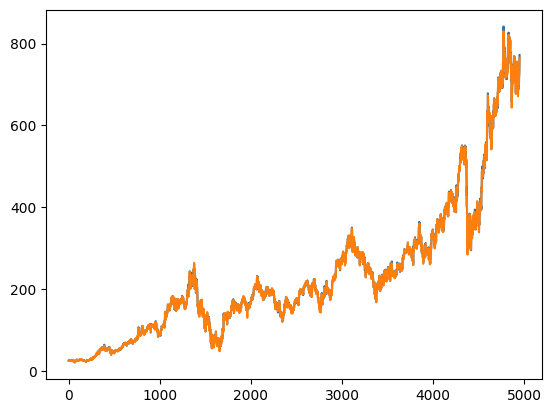

In [ ]:
print(len(transformed_prediction_list), len(testing_data[30:]))
plt.plot(transformed_prediction_list)
plt.plot(pd.DataFrame(testing_data[30:])[0])

In [ ]:
transformed_prediction_list = np.array(transformed_prediction_list)
testing_data_np = np.array(testing_data[30:][0])

print(transformed_prediction_list.shape, testing_data_np.shape)
error = 0
for i in range(0,len(testing_data_np)):
  buffer_error = math.sqrt((transformed_prediction_list[i] - testing_data_np[i])*(transformed_prediction_list[i] - testing_data_np[i]))
  error += buffer_error

test_stock_rmse = error/len(testing_data_np)
print("Final rmse: ", error/len(testing_data_np))

(4948, 1) (2,)
Final rmse:  0.17734622974362532


##Check tomorrow's prediction

In [ ]:
last_30, buffer_tar = scale(testing_data[-30:], 0, 0)
print(np.array(last_30).shape)

(30, 2)


In [ ]:
last_30_reshape = np.array(last_30).reshape(1,30,2)

In [ ]:
prediction = model.predict(last_30_reshape)

1/1 [==============================] - 0s 30ms/step


In [ ]:
dict_values = scaling_dict[0]
pred = inverse_scale_target(prediction, dict_values[0], dict_values[1])

[765.34997559 759.90002441]
[[760.99713]]


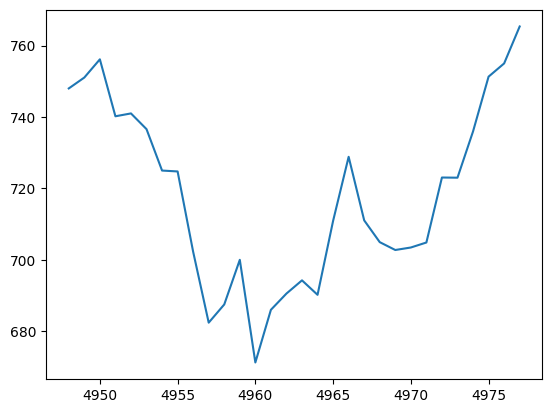

In [ ]:
plt.plot(pd.DataFrame(testing_data).iloc[-30:, 0])
print(testing_data[-1])
print(pred)

##Check how accurate regression is

In [ ]:
preds, actual_close = pd.DataFrame(np.array(transformed_prediction_list)), pd.DataFrame(np.array(testing_data[30:]))
dataframe = pd.concat([preds, actual_close], axis=1)
dataframe.columns = ['preds', 'actual open', 'actual close']
dataframe

,preds,actual open,actual close
0,24.769958,24.545454,24.427273
1,24.557461,24.545454,24.418180
2,24.529226,24.472727,24.054544
3,24.207357,24.054544,24.054544
4,24.155994,24.090908,24.400000
...,...,...,...
4943,721.871033,723.000000,725.950012
4944,728.536133,735.950012,742.000000
4945,744.718262,751.299988,755.700012
4946,758.267639,755.000000,769.500000


In [ ]:
fp = 0
fn = 0
tn = 0
tp = 0

for i in range(0, dataframe.shape[0]-1):
    if dataframe.iloc[i+1][0] > dataframe.iloc[i][2] and dataframe.iloc[i+1][1]>dataframe.iloc[i][2]:
        tp += 1
    elif dataframe.iloc[i+1][0] > dataframe.iloc[i][2] and dataframe.iloc[i+1][1]<dataframe.iloc[i][2]:
        fp += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][2] and dataframe.iloc[i+1][1]<dataframe.iloc[i][2]:
        tn += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][2] and dataframe.iloc[i+1][1]>dataframe.iloc[i][2]:
        fn += 1

test_stock_matrix = (tp, fp ,fn,tn)
test_stock_accuracy = tp/(tp+fp)

In [ ]:
print(tp,fp,fn, tn)

2883 1841 57 25


In [ ]:
tp /(tp +fp )

0.6102878916172735

#Results of above

In [ ]:
print("base stock rmse: ", base_stock_rmse)
print("base stock matrix: ", base_stock_matrix)
print("test stock rmse: ", test_stock_rmse)
print("test stock accuracy: ", test_stock_accuracy)
print("test stock matrix: ", test_stock_matrix)

base stock rmse:  1.6295776593932856
base stock matrix:  (742, 515, 14, 10)
test stock rmse:  0.17734622974362532
test stock accuracy:  0.6102878916172735
test stock matrix:  (2883, 1841, 57, 25)


#Use 3 features, Open, Close and Volume


##Create Targets and scale the data

The target is going to be next day's closing price. The batches will be create accordingly.

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,3.030,3.030000,2.925000,2.980000,2.389958,350000
1996-01-02,2.980,3.025000,2.950000,2.975000,2.385947,412000
1996-01-03,2.975,2.995000,2.950000,2.985000,2.393967,284000
1996-01-04,2.985,2.980000,2.940000,2.965000,2.377927,282000
1996-01-05,2.965,2.980000,2.950000,2.960000,2.373918,189000
...,...,...,...,...,...,...
2022-07-06,1348.000,1373.400024,1347.099976,1371.250000,1371.250000,7524539
2022-07-07,1380.000,1398.000000,1374.449951,1395.800049,1395.800049,8871571
2022-07-08,1410.000,1410.000000,1394.750000,1397.099976,1397.099976,6237015


In [ ]:
feature = np.array(df[['Open', 'Close', 'Volume']])

print(feature.shape)

import math

training_data_len = math.ceil(feature.shape[0] *0.8)
print(training_data_len)
training_data = feature[:training_data_len]
testing_data = feature[training_data_len:]
print(training_data.shape, testing_data.shape)

(6676, 3)
5341
(5341, 3) (1335, 3)


In [ ]:
training_data[:32]

array([[3.02999997e+00, 2.98000002e+00, 3.50000000e+05],
       [2.98000002e+00, 2.97499990e+00, 4.12000000e+05],
       [2.97499990e+00, 2.98499990e+00, 2.84000000e+05],
       [2.98499990e+00, 2.96499991e+00, 2.82000000e+05],
       [2.96499991e+00, 2.96000004e+00, 1.89000000e+05],
       [2.96000004e+00, 2.92499995e+00, 2.37000000e+05],
       [2.92499995e+00, 2.82999992e+00, 4.83000000e+05],
       [2.82999992e+00, 2.83999991e+00, 2.26000000e+05],
       [2.83999991e+00, 2.82999992e+00, 3.18000000e+05],
       [2.82999992e+00, 2.82500005e+00, 4.31000000e+05],
       [2.82500005e+00, 2.78999996e+00, 1.81000000e+05],
       [2.78999996e+00, 2.74000001e+00, 3.58000000e+05],
       [2.74000001e+00, 2.65499997e+00, 4.29000000e+05],
       [2.65499997e+00, 2.64000010e+00, 3.30000000e+05],
       [2.64000010e+00, 2.55500007e+00, 4.26000000e+05],
       [2.55500007e+00, 2.54500008e+00, 3.59000000e+05],
       [2.54500008e+00, 2.52999997e+00, 3.99000000e+05],
       [2.52999997e+00, 2.46499

In [ ]:
batches_training = []
targets_training = []
vol_batches_training = []

for i in range(30,len(training_data)):
    buffer_array = list(training_data[i-30:i,:-1])
    targets_training.append(training_data[i][0])
    batches_training.append(buffer_array)
    vol_batches_training.append(list(training_data[i-30:i, -1]))

print(np.array(batches_training).shape, np.array(targets_training).shape, np.array(vol_batches_training).shape)

(5311, 30, 2) (5311,) (5311, 30)


In [ ]:
#Define batch scaling function
scaled_training_data = []
scaled_training_targets = []
scaled_volume_data = []

def scale(x, buffer_target):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  new_seq = []
  for j in seq_x:
    buffer_seq = []
    for k in j:
      new_k = (k-min_x)/(max_x-min_x)
      buffer_seq.append(new_k)
    new_seq.append(buffer_seq)
  scaled_target = (buffer_target-min_x)/(max_x-min_x)
  return new_seq, scaled_target

def scale_vol(x):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  new_seq = []
  for k in seq_x:
    new_k = (k-min_x)/(max_x-min_x)
    new_seq.append(new_k)
  return new_seq

for i in range(0, len(batches_training)):
  seq = batches_training[i]
  buffer_target = targets_training[i]
  vol_seq = vol_batches_training[i]
  new_seq, scaled_target = scale(seq, buffer_target)
  new_vol_seq = scale_vol(vol_seq)
  scaled_training_data.append(new_seq)
  scaled_training_targets.append(scaled_target)
  scaled_volume_data.append(new_vol_seq)



print(np.array(scaled_training_data).shape, np.array(scaled_training_targets).shape, np.array(scaled_volume_data).shape)
print(x_train.shape, y_train.shape)

(5311, 30, 2) (5311,) (5311, 30)
(5311, 30, 2) (5311,)


In [ ]:
x_train = []
for i in range(0, len(scaled_training_data)):
  seq = list(scaled_training_data[i])
  vol_seq = list(scaled_volume_data[i])
  buffer_arr = []
  for j in range(0, len(seq)):
    buffer_seq = list(seq[j])
    buffer_seq.append(vol_seq[j])
    buffer_arr.append(buffer_seq)
  x_train.append(buffer_arr)

x_train = np.array(x_train)
y_train = np.array(scaled_training_targets)
print(x_train.shape, y_train.shape)

(5311, 30, 3) (5311,)


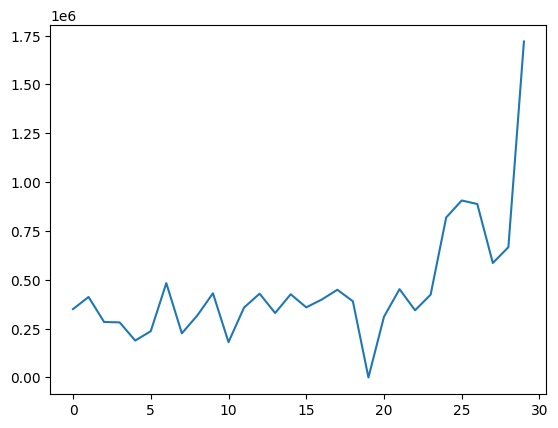

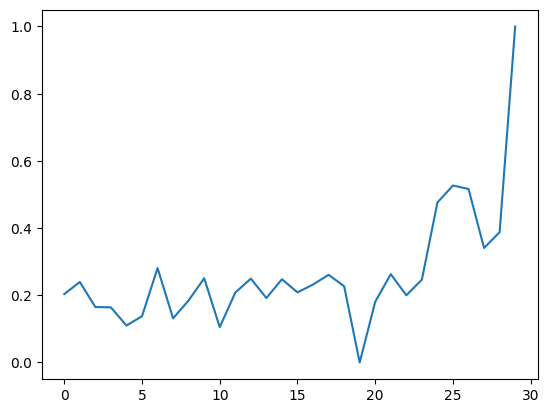

In [ ]:
plt.plot(pd.DataFrame(vol_batches_training[0]))
plt.show()
plt.plot(pd.DataFrame(scaled_volume_data[0]))
plt.show()

In [ ]:
# np.array(scaled_data).shape

# x_train = []
# y_train = []
# for i in range(0, len(scaled_data)):
#     seq = scaled_data[i]
#     x_train.append(seq[0:-1])
#     y_train.append(seq[-1])

# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# print(x_train.shape, y_train.shape)

##Model Architecture

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
## epochs = 9
history = model.fit(x_train, y_train, batch_size=256, epochs=40, validation_split=0.2)

Epoch 1/40
17/17 [==============================] - 7s 170ms/step - loss: 0.1798 - val_loss: 0.0912
Epoch 2/40
17/17 [==============================] - 4s 238ms/step - loss: 0.0766 - val_loss: 0.0642
Epoch 3/40
17/17 [==============================] - 3s 172ms/step - loss: 0.0590 - val_loss: 0.0479
Epoch 4/40
17/17 [==============================] - 2s 124ms/step - loss: 0.0493 - val_loss: 0.0393
Epoch 5/40
17/17 [==============================] - 2s 123ms/step - loss: 0.0438 - val_loss: 0.0358
Epoch 6/40
17/17 [==============================] - 2s 123ms/step - loss: 0.0394 - val_loss: 0.0319
Epoch 7/40
17/17 [==============================] - 3s 193ms/step - loss: 0.0352 - val_loss: 0.0281
Epoch 8/40
17/17 [==============================] - 3s 146ms/step - loss: 0.0314 - val_loss: 0.0241
Epoch 9/40
17/17 [==============================] - 2s 122ms/step - loss: 0.0269 - val_loss: 0.0197
Epoch 10/40
17/17 [==============================] - 2s 120ms/step - loss: 0.0223 - val_loss: 0.0152

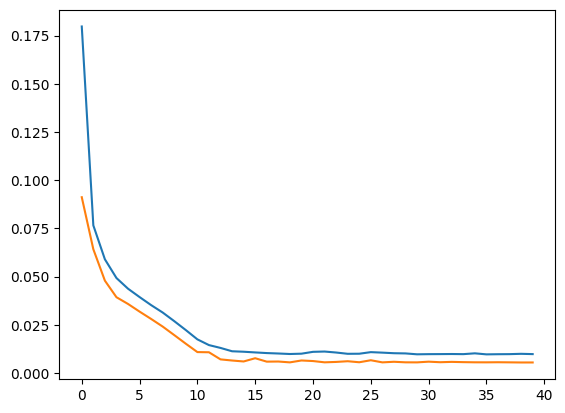

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

##Creating testing batches

In [ ]:
batches_testing = []
targets_testing = []
vol_batches_testing = []

for i in range(30,len(testing_data)):
    buffer_array = list(testing_data[i-30:i,:-1])
    targets_testing.append(testing_data[i][0])
    batches_testing.append(buffer_array)
    vol_batches_testing.append(list(testing_data[i-30:i, -1]))

print(np.array(batches_testing).shape, np.array(targets_testing).shape, np.array(vol_batches_testing).shape)


(1305, 30, 2) (1305,) (1305, 30)


In [ ]:
#Define batch scaling function
scaled_testing_data = []
scaled_testing_targets = []
scaled_testing_volume_data = []

scaling_dict = {}
def inverse_scale_data(x, min_x, max_x):
  orig_seq = []
  for j in x:
    buffer_array = []
    for k in j:
      orig_k = k*(max_x-min_x) + min_x
      buffer_array.append(orig_k)
    orig_seq.append(buffer_array)
  return orig_seq

def inverse_scale_target(x, min_x, max_x):
  orig_x = x*(max_x-min_x) + min_x
  return orig_x

def scale_vol(x):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  new_seq = []
  for k in seq_x:
    new_k = (k-min_x)/(max_x-min_x)
    new_seq.append(new_k)
  return new_seq

def scale(x, buffer_target,i):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  scaling_dict[i] = (min_x, max_x)
  new_seq = []
  for j in seq_x:
    buffer_seq = []
    for k in j:
      new_k = (k-min_x)/(max_x-min_x)
      buffer_seq.append(new_k)
    new_seq.append(buffer_seq)
  scaled_target = (buffer_target-min_x)/(max_x-min_x)
  return new_seq, scaled_target


for i in range(0, len(batches_testing)):
  seq = batches_testing[i]
  buffer_target = targets_testing[i]
  vol_seq = vol_batches_testing[i]
  new_vol_seq = scale_vol(vol_seq)
  new_seq, scaled_target = scale(seq, buffer_target, i)
  scaled_testing_data.append(new_seq)
  scaled_testing_targets.append(scaled_target)
  scaled_testing_volume_data.append(new_vol_seq)

print(np.array(scaled_testing_data).shape, np.array(scaled_testing_targets).shape, np.array(scaled_testing_volume_data).shape)

(1305, 30, 2) (1305,) (1305, 30)


In [ ]:
len(scaling_dict.keys())

1305

In [ ]:
x_test = []
for i in range(0, len(scaled_testing_data)):
  seq = list(scaled_testing_data[i])
  vol_seq = list(scaled_testing_volume_data[i])
  buffer_arr = []
  for j in range(0, len(seq)):
    buffer_seq = list(seq[j])
    buffer_seq.append(vol_seq[j])
    buffer_arr.append(buffer_seq)
  x_test.append(buffer_arr)

x_test = np.array(x_test)
y_test = np.array(scaled_testing_targets)
print(x_train.shape, y_train.shape)

(5311, 30, 3) (5311,)


##Testing

In [ ]:
model.evaluate(x_test, y_test)

41/41 [==============================] - 1s 13ms/step - loss: 0.0066


0.006633469369262457

In [ ]:
prediction_list = model.predict(x_test)

41/41 [==============================] - 2s 15ms/step


In [ ]:
transformed_prediction_list = []

for i in range(0,len(prediction_list)):
    dict_values = list(scaling_dict[i])
    or_seq = inverse_scale_target(prediction_list[i], dict_values[0], dict_values[1])
    transformed_prediction_list.append(or_seq)

1305 1305


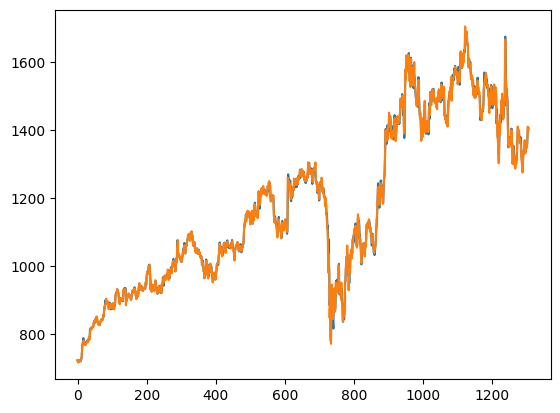

In [ ]:
print(len(transformed_prediction_list), len(testing_data[30:]))
plt.plot(transformed_prediction_list)
plt.plot(pd.DataFrame(testing_data[30:])[0])

In [ ]:
transformed_prediction_list = np.array(transformed_prediction_list)
testing_data_np = np.array(pd.DataFrame(testing_data[30:])[0])

print(transformed_prediction_list.shape, testing_data_np.shape)
error = 0
for i in range(0,len(testing_data_np)):
  buffer_error = math.sqrt((transformed_prediction_list[i] - testing_data_np[i])*(transformed_prediction_list[i] - testing_data_np[i]))
  error += buffer_error

base_stock_rmse = error/len(testing_data_np)
print("Final rmse: ", error/len(testing_data_np))

(1305, 1) (1305,)
Final rmse:  6.842296710527515


##Check how accurate regression is

In [ ]:
preds, actual_close = pd.DataFrame(np.array(transformed_prediction_list)), pd.DataFrame(np.array(testing_data[30:]))
dataframe = pd.concat([preds, actual_close], axis=1)
dataframe.columns = ['preds', 'actual open', 'actual close', 'volume']
dataframe

,preds,actual open,actual close,volume
0,721.440002,723.000000,716.599976,2074526.0
1,717.614624,717.625000,716.174988,2872040.0
2,716.546875,715.750000,719.250000,3062208.0
3,719.648743,715.525024,719.424988,2324180.0
4,719.679932,721.500000,717.075012,1696938.0
...,...,...,...,...
1300,1354.651245,1348.000000,1371.250000,7524539.0
1301,1373.692749,1380.000000,1395.800049,8871571.0
1302,1399.287842,1410.000000,1397.099976,6237015.0
1303,1397.712036,1394.000000,1406.150024,3731416.0


In [ ]:
fp = 0
fn = 0
tn = 0
tp = 0

for i in range(0, dataframe.shape[0]-1):
    if dataframe.iloc[i+1][0] > dataframe.iloc[i][2] and dataframe.iloc[i+1][1]>dataframe.iloc[i][2]:
        tp += 1
    elif dataframe.iloc[i+1][0] > dataframe.iloc[i][2] and dataframe.iloc[i+1][1]<dataframe.iloc[i][2]:
        fp += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][2] and dataframe.iloc[i+1][1]<dataframe.iloc[i][2]:
        tn += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][2] and dataframe.iloc[i+1][1]>dataframe.iloc[i][2]:
        fn += 1

base_stock_matrix = (tp,fp,fn,tn)
base_stock_accuracy = tp/(tp+fp)

In [ ]:
print(tp,fp,fn, tn)

676 475 80 50


In [ ]:
tp /(tp +fp )

0.5873153779322329

##Testing on test_stock

In [ ]:
df_IGL = pdr.get_data_yahoo(test_stock, start="1980-02-01", end="2022-07-13")

[*********************100%***********************]  1 of 1 completed


In [ ]:
testing_data = np.array(df_IGL[['Open', 'Close', 'Volume']])

import math

print(testing_data.shape)

(4978, 3)


In [ ]:
batches_testing = []
targets_testing = []
vol_batches_testing = []

for i in range(30,len(testing_data)):
    buffer_array = list(testing_data[i-30:i,:-1])
    targets_testing.append(testing_data[i][0])
    batches_testing.append(buffer_array)
    vol_batches_testing.append(list(testing_data[i-30:i, -1]))

print(np.array(batches_testing).shape, np.array(targets_testing).shape, np.array(vol_batches_testing).shape)


(4948, 30, 2) (4948,) (4948, 30)


In [ ]:
#Define batch scaling function
scaled_testing_data = []
scaled_testing_targets = []
scaled_testing_volume_data = []

scaling_dict = {}
def inverse_scale_data(x, min_x, max_x):
  orig_seq = []
  for j in x:
    buffer_array = []
    for k in j:
      orig_k = k*(max_x-min_x) + min_x
      buffer_array.append(orig_k)
    orig_seq.append(buffer_array)
  return orig_seq

def inverse_scale_target(x, min_x, max_x):
  orig_x = x*(max_x-min_x) + min_x
  return orig_x

def scale_vol(x):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  new_seq = []
  for k in seq_x:
    new_k = (k-min_x)/(max_x-min_x)
    new_seq.append(new_k)
  return new_seq

def scale(x, buffer_target,i):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  scaling_dict[i] = (min_x, max_x)
  new_seq = []
  for j in seq_x:
    buffer_seq = []
    for k in j:
      new_k = (k-min_x)/(max_x-min_x)
      buffer_seq.append(new_k)
    new_seq.append(buffer_seq)
  scaled_target = (buffer_target-min_x)/(max_x-min_x)
  return new_seq, scaled_target


for i in range(0, len(batches_testing)):
  seq = batches_testing[i]
  buffer_target = targets_testing[i]
  vol_seq = vol_batches_testing[i]
  new_vol_seq = scale_vol(vol_seq)
  new_seq, scaled_target = scale(seq, buffer_target, i)
  scaled_testing_data.append(new_seq)
  scaled_testing_targets.append(scaled_target)
  scaled_testing_volume_data.append(new_vol_seq)

print(np.array(scaled_testing_data).shape, np.array(scaled_testing_targets).shape, np.array(scaled_testing_volume_data).shape)

(4948, 30, 2) (4948,) (4948, 30)


In [ ]:
x_test = []
for i in range(0, len(scaled_testing_data)):
  seq = list(scaled_testing_data[i])
  vol_seq = list(scaled_testing_volume_data[i])
  buffer_arr = []
  for j in range(0, len(seq)):
    buffer_seq = list(seq[j])
    buffer_seq.append(vol_seq[j])
    buffer_arr.append(buffer_seq)
  x_test.append(buffer_arr)

x_test = np.array(x_test)
y_test = np.array(scaled_testing_targets)
print(x_train.shape, y_train.shape)

(5311, 30, 3) (5311,)


In [ ]:
prediction_list = model.predict(x_test)


155/155 [==============================] - 2s 12ms/step


In [ ]:
transformed_prediction_list = []

for i in range(0,len(prediction_list)):
    dict_values = list(scaling_dict[i])
    or_seq = inverse_scale_target(prediction_list[i], dict_values[0], dict_values[1])
    transformed_prediction_list.append(or_seq)

4948 4948


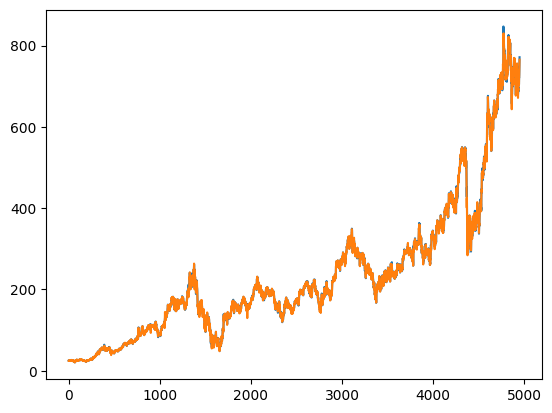

In [ ]:
print(len(transformed_prediction_list), len(testing_data[30:]))
plt.plot(transformed_prediction_list)
plt.plot(pd.DataFrame(testing_data[30:])[0])

In [ ]:
transformed_prediction_list = np.array(transformed_prediction_list)
testing_data_np = np.array(pd.DataFrame(testing_data[30:])[0])

print(transformed_prediction_list.shape, testing_data_np.shape)
error = 0
for i in range(0,len(testing_data_np)):
  buffer_error = math.sqrt((transformed_prediction_list[i] - testing_data_np[i])*(transformed_prediction_list[i] - testing_data_np[i]))
  error += buffer_error

test_stock_rmse = error/len(testing_data_np)
print("Final rmse: ", error/len(testing_data_np))

(4948, 1) (4948,)
Final rmse:  1.8793694966963996


##Check how accurate regression is

In [ ]:
preds, actual_close = pd.DataFrame(np.array(transformed_prediction_list)), pd.DataFrame(np.array(testing_data[30:]))
dataframe = pd.concat([preds, actual_close], axis=1)
dataframe.columns = ['preds', 'actual open', 'actual close', 'volume']
dataframe

,preds,actual open,actual close,volume
0,24.703529,24.545454,24.427273,467516.0
1,24.476158,24.545454,24.418180,710748.0
2,24.464083,24.472727,24.054544,573578.0
3,24.096792,24.054544,24.054544,0.0
4,24.071665,24.090908,24.400000,416421.0
...,...,...,...,...
4943,720.659912,723.000000,725.950012,12163533.0
4944,727.705811,735.950012,742.000000,10374018.0
4945,743.819763,751.299988,755.700012,9797700.0
4946,757.074219,755.000000,769.500000,12440573.0


In [ ]:
fp = 0
fn = 0
tn = 0
tp = 0

for i in range(0, dataframe.shape[0]-1):
    if dataframe.iloc[i+1][0] > dataframe.iloc[i][2] and dataframe.iloc[i+1][1]>dataframe.iloc[i][2]:
        tp += 1
    elif dataframe.iloc[i+1][0] > dataframe.iloc[i][2] and dataframe.iloc[i+1][1]<dataframe.iloc[i][2]:
        fp += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][2] and dataframe.iloc[i+1][1]<dataframe.iloc[i][2]:
        tn += 1
    elif dataframe.iloc[i+1][0] < dataframe.iloc[i][2] and dataframe.iloc[i+1][1]>dataframe.iloc[i][2]:
        fn += 1

test_stock_matrix = (tp,fp,fn,tn)
test_stock_accuracy = tp/(tp+fp)

In [ ]:
print(tp,fp,fn, tn)

2618 1662 322 204


In [ ]:
tp /(tp +fp )

0.6116822429906542

#Results of above


In [ ]:
print("base stock rmse: ", base_stock_rmse)
print("base stock matrix: ", base_stock_matrix)
print("test stock rmse: ", test_stock_rmse)
print("test stock accuracy: ", test_stock_accuracy)
print("test stock matrix: ", test_stock_matrix)

base stock rmse:  6.842296710527515
base stock matrix:  (676, 475, 80, 50)
test stock rmse:  1.8793694966963996
test stock accuracy:  0.6116822429906542
test stock matrix:  (2618, 1662, 322, 204)
